In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from langdetect import detect
import itertools
import string
import collections
from collections import Counter

In [2]:
df = pd.read_csv('reviews.csv')
df

,Customer Review,text
0,Review 1,I travel alot and really enjoyed my stay here....
1,Review 2,Stayed one night for a seminar at the Universi...
2,Review 3,I stayed at the the BW Downtown on two separat...
3,Review 4,This is my first year to go to with a group of...
4,Review 5,I travel with several friends (we're from a sm...
...,...,...
195,Review 196,We try to use any excuse to celebrate a weeken...
196,Review 197,"The Sorella is a nice, contemporary hotel. Qui..."
197,Review 198,Dieses ist immer wieder eines meiner Favourite...
198,Review 199,Sch√∂ne Zimmer und sind sehr gut eingerichtet....


In [84]:
df['word_count'] = df['text'].str.split().apply(len)
df['language'] = df['text'].apply(lambda x: detect(x))
new_df=df.drop(df[df.language != 'en'].index)
new_df['Customer Review'] = new_df['Customer Review'].str.slice(6,20)
new_df['Customer Review'] = new_df['Customer Review'].astype(str).astype(int)
new_df

,Customer Review,text,word_count,language
0,1,I travel alot and really enjoyed my stay here....,39,en
1,2,Stayed one night for a seminar at the Universi...,76,en
2,3,I stayed at the the BW Downtown on two separat...,241,en
3,4,This is my first year to go to with a group of...,97,en
4,5,I travel with several friends (we're from a sm...,77,en
...,...,...,...,...
193,194,"Got a Deluxe Room facing the ""green"" to watch ...",61,en
194,195,"The Hotel was super clean, nice modern-retro d...",81,en
195,196,We try to use any excuse to celebrate a weeken...,100,en
196,197,"The Sorella is a nice, contemporary hotel. Qui...",28,en


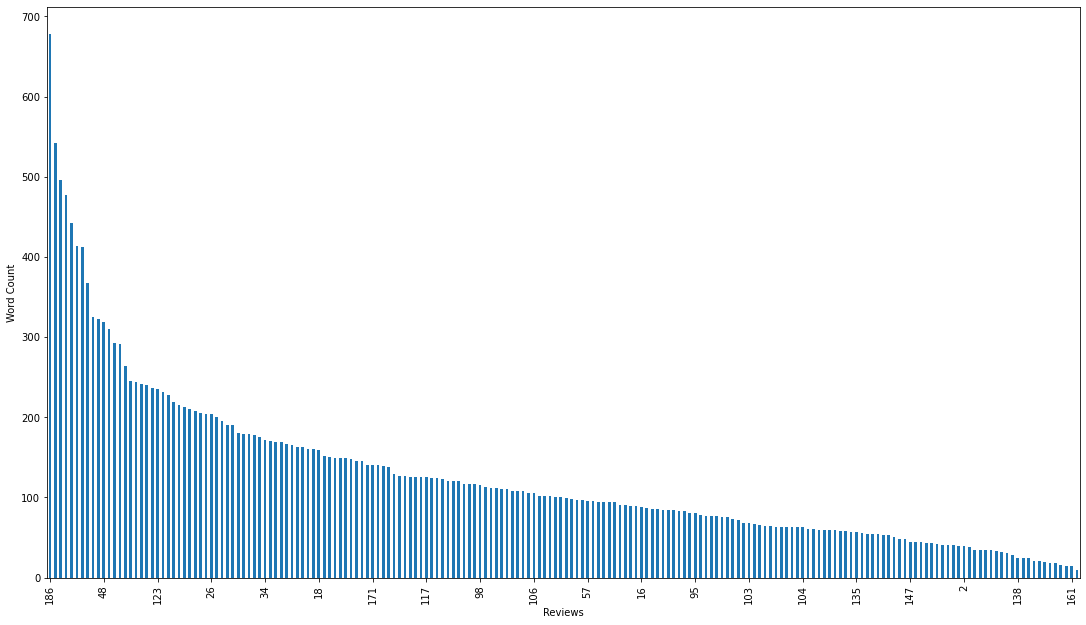

In [144]:
new_df['word_count'].describe()
# df_sorted = new_df.sort_values(by = 'word_count', ascending = False)
df_sorted = pd.DataFrame(new_df.sort_values(by = 'word_count', ascending = False), columns = ['word_count','Customer Review'])
df_sorted['word_count'].plot(kind="bar")
plt.xticks(range(0, 192, 10))
plt.xlabel('Reviews')
plt.ylabel('Word Count')
#Figure
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('Word Statistic', dpi=100)
# Need to add a boxplot based on statistics



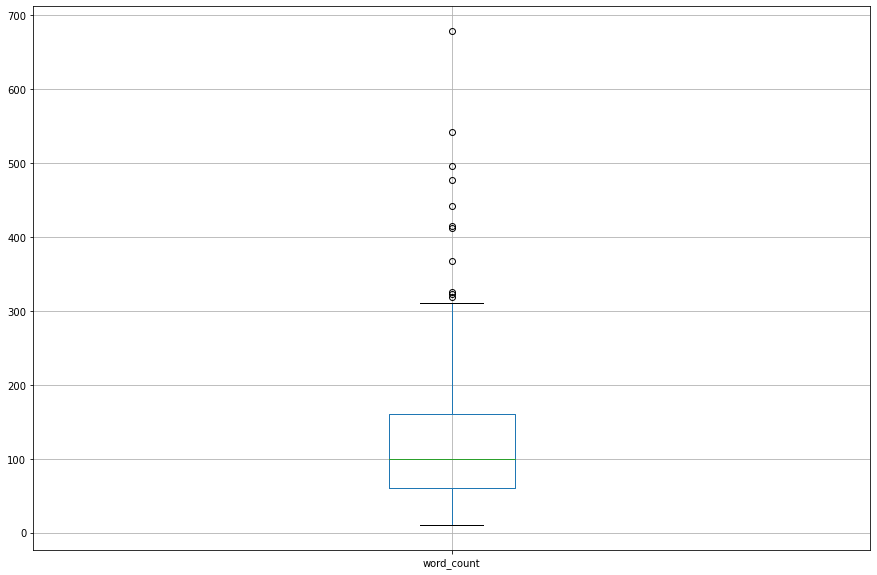

In [117]:
df_sorted.boxplot(column =['word_count'], grid = True) 

#Figure
fig = plt.gcf()
fig.set_size_inches(15, 10)
fig.savefig('Box Plot', dpi=100)

In [113]:
df_sorted.describe()

,word_count,Customer Review
count,192.000000,192.000000
mean,126.421875,98.692708
std,102.008028,56.895646
min,10.000000,1.000000
25%,60.000000,49.750000
50%,99.500000,98.500000
75%,160.750000,147.250000
max,678.000000,200.000000


In [142]:
df_sorted.tail(10)

,word_count,Customer Review
67,24,68
177,21,178
179,21,180
185,19,186
79,18,80
165,18,166
27,16,28
58,14,59
172,14,173
36,10,37


In [146]:
wn = WordNetLemmatizer()
ps = nltk.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def clean_text_1(text):
    text = "".join([word for word in text if word not in string.punctuation])#Punctuation
#     text = "".join([word for word in text if not word.isdigit()])#NUmbers
#     tokens = re.split('\W+', text)#Tokenize
#     text = [word for word in tokens if word not in stopword]#Stopwords
    return text
def clean_text_2(text):
    text = "".join([word for word in text if not word.isdigit()])#NUmbers
    return text
def clean_text_3(text):
    tokens = re.split('\W+', text)#Tokenize
    text = [word for word in tokens if word not in stopword]#Stopwords
    return text


new_df['body_clean_punct'] = new_df['text'].apply(lambda x: clean_text_1(x.lower())) #Revmove Punctuation
new_df['body_clean_nodigits'] = new_df['body_clean_punct'].apply(lambda x: clean_text_2(x.lower())) #Remove Numbers
new_df['body_clean_token_stopwords'] = new_df['body_clean_nodigits'].apply(lambda x: clean_text_3(x.lower())) #Tokenized and Remove Stopwords


# new_df['body_clean'] = new_df['text'].apply(lambda x: clean_text(x.lower())) #Remove punctuation & stopwords, normalized, numbers and tokenized

def stem(stem_text):
    text = [ps.stem(word) for word in stem_text]
    return text

new_df['body_clean_stem'] = new_df['body_clean_token_stopwords'].apply(lambda x: stem(x)) #Stemming Performed

def lemmatizer(lem_text):
    text = [wn.lemmatize(word, pos = 'v') for word in lem_text]
    return text

new_df['body_clean_lem'] = new_df['body_clean_token_stopwords'].apply(lambda x: lemmatizer(x)) #Lemmatization Performed

new_df

,Customer Review,text,word_count,language,body_clean_punct,body_clean_nodigits,body_clean_token_stopwords,body_clean_stem,body_clean_lem
0,1,I travel alot and really enjoyed my stay here....,39,en,i travel alot and really enjoyed my stay here ...,i travel alot and really enjoyed my stay here ...,"[travel, alot, really, enjoyed, stay, hotel, c...","[travel, alot, realli, enjoy, stay, hotel, cle...","[travel, alot, really, enjoy, stay, hotel, cle..."
1,2,Stayed one night for a seminar at the Universi...,76,en,stayed one night for a seminar at the universi...,stayed one night for a seminar at the universi...,"[stayed, one, night, seminar, university, clea...","[stay, one, night, seminar, univers, clean, co...","[stay, one, night, seminar, university, clean,..."
2,3,I stayed at the the BW Downtown on two separat...,241,en,i stayed at the the bw downtown on two separat...,i stayed at the the bw downtown on two separat...,"[stayed, bw, downtown, two, separate, business...","[stay, bw, downtown, two, separ, busi, trip, n...","[stay, bw, downtown, two, separate, business, ..."
3,4,This is my first year to go to with a group of...,97,en,this is my first year to go to with a group of...,this is my first year to go to with a group of...,"[first, year, go, group, quilter, southeast, k...","[first, year, go, group, quilter, southeast, k...","[first, year, go, group, quilter, southeast, k..."
4,5,I travel with several friends (we're from a sm...,77,en,i travel with several friends were from a smal...,i travel with several friends were from a smal...,"[travel, several, friends, small, town, girls,...","[travel, sever, friend, small, town, girl, wee...","[travel, several, friends, small, town, girls,..."
...,...,...,...,...,...,...,...,...,...
193,194,"Got a Deluxe Room facing the ""green"" to watch ...",61,en,got a deluxe room facing the green to watch th...,got a deluxe room facing the green to watch th...,"[got, deluxe, room, facing, green, watch, th, ...","[got, delux, room, face, green, watch, th, jul...","[get, deluxe, room, face, green, watch, th, ju..."
194,195,"The Hotel was super clean, nice modern-retro d...",81,en,the hotel was super clean nice modernretro des...,the hotel was super clean nice modernretro des...,"[hotel, super, clean, nice, modernretro, desig...","[hotel, super, clean, nice, modernretro, desig...","[hotel, super, clean, nice, modernretro, desig..."
195,196,We try to use any excuse to celebrate a weeken...,100,en,we try to use any excuse to celebrate a weeken...,we try to use any excuse to celebrate a weeken...,"[try, use, excuse, celebrate, weekend, hotel, ...","[tri, use, excus, celebr, weekend, hotel, sore...","[try, use, excuse, celebrate, weekend, hotel, ..."
196,197,"The Sorella is a nice, contemporary hotel. Qui...",28,en,the sorella is a nice contemporary hotel quiet...,the sorella is a nice contemporary hotel quiet...,"[sorella, nice, contemporary, hotel, quiet, ho...","[sorella, nice, contemporari, hotel, quiet, ho...","[sorella, nice, contemporary, hotel, quiet, ho..."


In [147]:
#Most common words in all documents
all_words = new_df['body_clean_lem'].tolist()
all_words_2 = list(itertools.chain(*all_words))
counts_all_words_2 = collections.Counter(all_words_2)
common_words = pd.DataFrame(counts_all_words_2.most_common(), columns=['words', 'count']) #gets the most common words in all of the documents
common_words.head(20)

,words,count
0,hotel,317
1,room,263
2,stay,211
3,staff,150
4,great,121
5,clean,92
6,breakfast,92
7,nice,91
8,get,84
9,good,83


In [148]:
# Creates the TF matrix 
count_vect  = CountVectorizer(analyzer = lemmatizer) #analyzer hyperparameter directly runs the fuction created
X_count_vect = count_vect.fit_transform(new_df['body_clean_lem'])
X_count_df = pd.DataFrame(X_count_vect.toarray()) #changes sparse matrix into an array 
X_count_df.columns = count_vect.get_feature_names()
tf_mat = X_count_df.div(X_count_df.sum(axis = 1), axis = 0) #Divides all the values within the matrix by the sum of each document
tf_mat

sum_column_1 = pd.DataFrame(tf_mat.sum(axis = 0), columns = ['weightage'])
sort_tf = sum_column_1.sort_values(by = ['weightage'],ascending=[False])
sort_tf.head(20)

,weightage
hotel,5.360935
room,4.512253
stay,4.135204
staff,2.920348
great,2.522929
clean,2.013104
nice,1.739766
breakfast,1.578071
good,1.512856
location,1.381673


In [149]:
# Creates the TF-IDF matrix 
tfidf_vect = TfidfVectorizer(analyzer = lemmatizer) #analyzer hyperparameter directly runs the fuction created
X_tfidf = tfidf_vect.fit_transform(new_df['body_clean_lem'])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf_vect.get_feature_names()
X_tfidf_df

sum_column_2 = pd.DataFrame(X_tfidf_df.sum(axis = 0), columns = ['weightage'])
sort_tfidf = sum_column_2.sort_values(by = ['weightage'],ascending=[False])
sort_tfidf.head(20)

,weightage
hotel,12.250793
room,10.623668
stay,10.314577
great,7.986070
staff,7.585320
nice,6.495658
clean,6.316662
good,5.689056
breakfast,5.587166
location,5.012565


In [16]:
common_words.head(20)

,words,count
0,hotel,317
1,room,263
2,stay,211
3,staff,150
4,great,121
5,clean,92
6,breakfast,92
7,nice,91
8,get,84
9,good,83


In [150]:
#Sentiment Labels
analyser = SentimentIntensityAnalyzer()
def sentiment_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

new_df['sentiment_score'] = new_df['text'].apply(lambda x: sentiment_scores(x)) #Sentiment score provided
new_df['compound_score'] = new_df['sentiment_score'].apply(lambda score_dict: score_dict['compound']) #Extract the compound score
new_df['label'] = new_df['compound_score'].apply(lambda c: 'GOOD' if c >=0 else 'BAD') #Label 'GOOD' if compoud score is greater that 0 and 'BAD' otherwise
new_df

,Customer Review,text,word_count,language,body_clean_punct,body_clean_nodigits,body_clean_token_stopwords,body_clean_stem,body_clean_lem,sentiment_score,compound_score,label
0,1,I travel alot and really enjoyed my stay here....,39,en,i travel alot and really enjoyed my stay here ...,i travel alot and really enjoyed my stay here ...,"[travel, alot, really, enjoyed, stay, hotel, c...","[travel, alot, realli, enjoy, stay, hotel, cle...","[travel, alot, really, enjoy, stay, hotel, cle...","{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'comp...",0.8882,GOOD
1,2,Stayed one night for a seminar at the Universi...,76,en,stayed one night for a seminar at the universi...,stayed one night for a seminar at the universi...,"[stayed, one, night, seminar, university, clea...","[stay, one, night, seminar, univers, clean, co...","[stay, one, night, seminar, university, clean,...","{'neg': 0.022, 'neu': 0.744, 'pos': 0.234, 'co...",0.9554,GOOD
2,3,I stayed at the the BW Downtown on two separat...,241,en,i stayed at the the bw downtown on two separat...,i stayed at the the bw downtown on two separat...,"[stayed, bw, downtown, two, separate, business...","[stay, bw, downtown, two, separ, busi, trip, n...","[stay, bw, downtown, two, separate, business, ...","{'neg': 0.023, 'neu': 0.847, 'pos': 0.129, 'co...",0.9781,GOOD
3,4,This is my first year to go to with a group of...,97,en,this is my first year to go to with a group of...,this is my first year to go to with a group of...,"[first, year, go, group, quilter, southeast, k...","[first, year, go, group, quilter, southeast, k...","[first, year, go, group, quilter, southeast, k...","{'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'comp...",0.9696,GOOD
4,5,I travel with several friends (we're from a sm...,77,en,i travel with several friends were from a smal...,i travel with several friends were from a smal...,"[travel, several, friends, small, town, girls,...","[travel, sever, friend, small, town, girl, wee...","[travel, several, friends, small, town, girls,...","{'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'comp...",0.9701,GOOD
...,...,...,...,...,...,...,...,...,...,...,...,...
193,194,"Got a Deluxe Room facing the ""green"" to watch ...",61,en,got a deluxe room facing the green to watch th...,got a deluxe room facing the green to watch th...,"[got, deluxe, room, facing, green, watch, th, ...","[got, delux, room, face, green, watch, th, jul...","[get, deluxe, room, face, green, watch, th, ju...","{'neg': 0.0, 'neu': 0.77, 'pos': 0.23, 'compou...",0.9300,GOOD
194,195,"The Hotel was super clean, nice modern-retro d...",81,en,the hotel was super clean nice modernretro des...,the hotel was super clean nice modernretro des...,"[hotel, super, clean, nice, modernretro, desig...","[hotel, super, clean, nice, modernretro, desig...","[hotel, super, clean, nice, modernretro, desig...","{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",0.9857,GOOD
195,196,We try to use any excuse to celebrate a weeken...,100,en,we try to use any excuse to celebrate a weeken...,we try to use any excuse to celebrate a weeken...,"[try, use, excuse, celebrate, weekend, hotel, ...","[tri, use, excus, celebr, weekend, hotel, sore...","[try, use, excuse, celebrate, weekend, hotel, ...","{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...",0.9688,GOOD
196,197,"The Sorella is a nice, contemporary hotel. Qui...",28,en,the sorella is a nice contemporary hotel quiet...,the sorella is a nice contemporary hotel quiet...,"[sorella, nice, contemporary, hotel, quiet, ho...","[sorella, nice, contemporari, hotel, quiet, ho...","[sorella, nice, contemporary, hotel, quiet, ho...","{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...",0.6908,GOOD


In [151]:
good_reviews = len(new_df[new_df['label']== 'GOOD'])
bad_reviews = len(new_df[new_df['label']== 'BAD'])
print('Number of good reviews are:', good_reviews)
print('Number of bad reviews are:', bad_reviews)

Number of good reviews are: 185
Number of bad reviews are: 7
